# Praca Domowa 5 - Budowa modeli
**Zespół budujący**
- Szymon Gut
- Jan Krężel

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np

### Wczytanie danych

In [3]:
urbanGB = pd.read_table("urbanGB.txt", sep=",")
urbanGB_centr = pd.read_table("urbanGB.centr.txt", sep=",")
urbanGB_labels = pd.read_table("urbanGB.labels.txt", sep=",")

Według źródła danych

> It is advisable to scale the longitude down by a factor of 1.7 for the purpose of geographical clustering.

Zatem dostosujemy się do tego. Ten zabieg pozwala na wykorzystanie odległości Euklidesowej z minimalnymi skutkami ubocznymi.

In [4]:
urbanGB['lng'] = urbanGB['lng'].div(1.7)
urbanGB_centr['longtitude'] = urbanGB_centr['longtitude'].div(1.7)

Podział zbioru do wykorzystania przy użyciu KMeans

In [5]:
urbanGB_train, urbanGB_test = train_test_split(urbanGB, test_size=0.2)

### Przedstawienie graficzne miejsc w których wystęowały wypadki

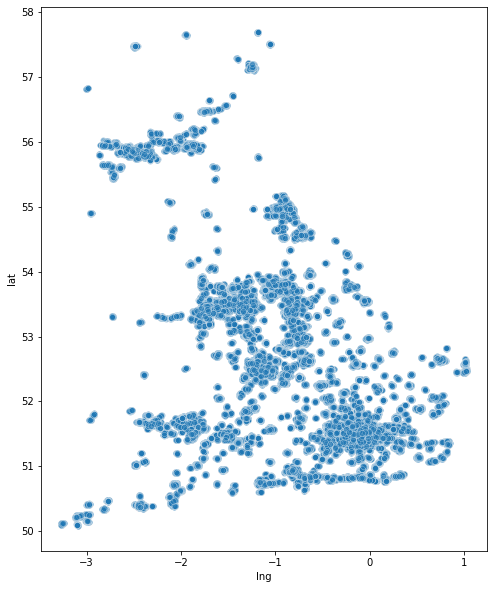

In [30]:
plt.figure(figsize=(8, 10))
sns.scatterplot(data=urbanGB, x='lng', y='lat', alpha=0.5, edgecolors=None)
plt.show()

### KMeans + Elbow Method

Pierwszym wykorzystanym modelem będzie ```KMeans```. Do wyznaczenie liczby klastrów wykorzystamy **Elbow method**.
W tej sekcji będziemy korzystać tylko z ```urbanGB_train```. Zespół walidujący ma przygotowany zestaw ```urgabGB_test```.

In [31]:
samples = urbanGB_train.to_numpy()

Wyznaczamy inercję modelu dla różnych wartości ```n_clusters```.

In [13]:
inertias = []
K = np.arange(6, 31, 2)
for k in K:
    print(f"Training model for {k} clusters... ", end='')
    model = KMeans(n_clusters = k)
    model.fit(samples)
    inertias.append(model.inertia_)
    print("Done!")


Training model for 6 clusters...Done!
Training model for 8 clusters...Done!
Training model for 10 clusters...Done!
Training model for 12 clusters...Done!
Training model for 14 clusters...Done!
Training model for 16 clusters...Done!
Training model for 18 clusters...Done!
Training model for 20 clusters...Done!
Training model for 22 clusters...Done!
Training model for 24 clusters...Done!
Training model for 26 clusters...Done!
Training model for 28 clusters...Done!


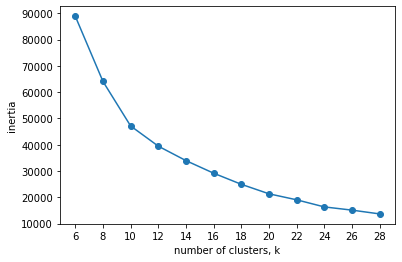

In [14]:
plt.plot(K, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(K)
plt.show()

Na wykresie możemy zobaczyć jak liczba klastrów wpływa na dokładność przybliżania naszych danych centroidami. Im mniejsza ```inertia``` tym nasze dane są bliżej centroidów. Jednak przy wyborze optymalnego modelu należy również zwrócić uwagę na liczbę klastrów. Dobry model to taki, który przy minimalnej liczbie klastrów osiąga niską wartość ```inertia```. Czyli wybierzemy ten model dla którego spadek na wykresię staje się nagle łagodniejszy

Patrząc na te dwa wykresy słusznym kandydatem na liczbę klastrów ***wydaje się*** 21. Jest to liczba, która dostatecznie minimalizuje nam wartość ```inertia``` oraz możemy zauważyć, że większe liczby klastrów tylko nieznacznie poprawiają nam wyniki.

Przy wizualizacji klastrów dodatkowo zaznaczymy pozycje największych miast w Wielkiej Brytanii. Pomoże to nam lepiej ocenić zachowanie i skuteczność algorytmów. Te dane uzyskaliśmy z [tej strony](https://simplemaps.com/data/gb-cities). Podobnie jak w przypadku oryginalnych danych tutaj także podzielimy atrybut ```longitude``` przez 1,7.

In [26]:
gb_cities = pd.read_csv('gb.csv')[['lat', 'lng', 'population_proper']]
gb_cities['lng'] = gb_cities['lng'].div(1.7)

In [71]:
# wytrenowanie kilku modeli do późniejszego użycia
kmeans_9 = KMeans(n_clusters=9).fit(samples)
kmeans_15 = KMeans(n_clusters=15).fit(samples)
kmeans_21 = KMeans(n_clusters=21).fit(samples)
kmeans_26 = KMeans(n_clusters=26).fit(samples)

In [72]:
kmeans_30 = KMeans(n_clusters=30).fit(samples)
kmeans_35 = KMeans(n_clusters=35).fit(samples)
kmeans_40 = KMeans(n_clusters=40).fit(samples)
kmeans_45 = KMeans(n_clusters=45).fit(samples)

In [75]:
def plot_clusters_over_cities(X, models):
    subset_size = X.shape[0]

    nrows = int(np.ceil(len(models) / 2))
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(18,10*nrows))
    axes = axes.flatten()

    for i, model in enumerate(models):
        city_centers = gb_cities.loc[:model.n_clusters]

        y_kmeans = model.labels_[:subset_size]
        try:
            centers = model.cluster_centers_
        except:
            centers = None

        ax = axes[i]
        sns.scatterplot(ax = ax, x=X[:, 0], y=X[:,1], hue=y_kmeans, palette='tab20', alpha=0.4)
        if centers is not None:
            sns.scatterplot(ax = ax, x=centers[:, 0], y=centers[:,1], s=200, palette=['black'], hue=0, marker='+')
        sns.scatterplot(ax = ax, x=city_centers['lng'], y=city_centers['lat'], s=200, palette=['red'], hue=0, marker='x')
        ax.set_title(f"n_clusters={model.n_clusters}")
        ax.get_legend().remove()
    

Na wykresie poniżej czarnymi plusami zaznaczone są wyznaczone centroidy klastrów natomiast czerownymi krzyżykami zaznaczone są największe (pod wzgledęm ludności) miasta w Wielkiej Brytanii. Liczba miast jest równa liczbie klastrów.

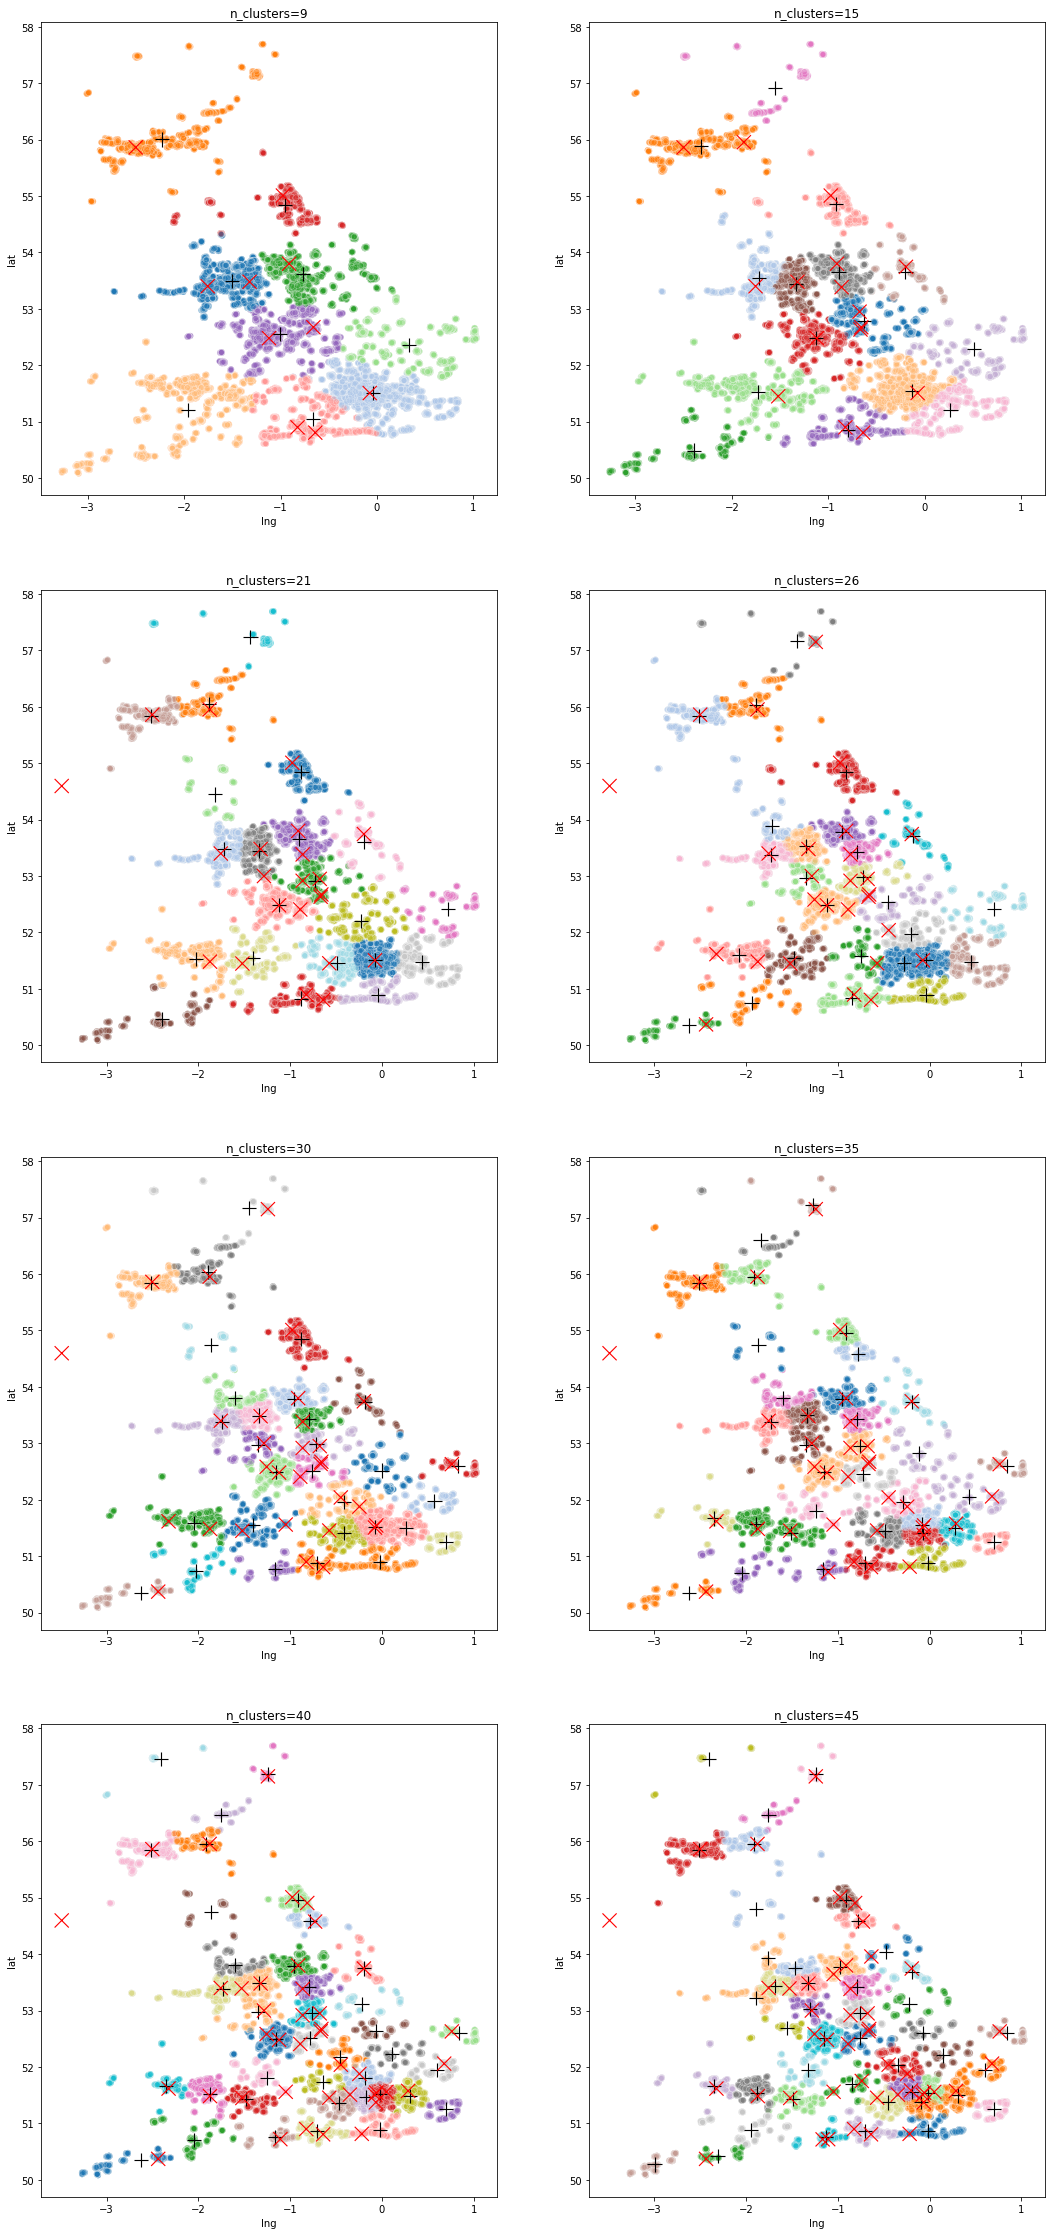

In [181]:
plot_clusters_over_cities(samples, [kmeans_9, kmeans_15, kmeans_21, kmeans_26, kmeans_30, kmeans_35, kmeans_40, kmeans_45])

Widzimy, że duża liczba klastrów nie jest bez sensowna. Jesteśmy wtedy w stanie przypisać większość miast do pewnego centroidu. Taka klasteryzacja ma wtedy już pewne zastosowanie. Na mapie widzimy też, że praktycznie każde miasto (oprócz Belfast) ma w pobliżu jakiś centroid. Natomiast nie każdy centroid ma przy sobie miasto (wynika to z tego, że często jeden centroid odpowiada całej aglomeracji). Być może te centroidy odpowiadają mniejszym miejscowościom lub drogom szybkiego ruchu.

### AgglomerativeClustering + Silhouette

Drugą wykorzystaną metodą klasteryzacji będzie ```AgglomerativeClustering```. Do wyznaczenia liczby klastrów skorzystamy z funkcji ```silhouette_score```.
Ta funkcja dla dużych zbiorów danych wykonuje się bardzo długo, dlatego wybierzemy tylko niewielki podzbiór naszych danych.

Do analizy wybierzemy liczby klastrów z przedziału [2, 469] (469 to liczba etykiet w ```urbanGB_labels```).
W tej sekcji będziemy już z powrotem używać całego zestawu.

In [ ]:
samples = urbanGB.to_numpy()

Algorytm ```AgglomerativeClustering``` potrzebuje **O(n^2)** pamięci, dlatego wykonamy go na niewielkim podzbiorze całego zbioru danych.

In [51]:
subset_size = int(0.03 * samples.shape[0]) # ~11k obserwacji

In [ ]:
# wyznaczenie silihouette
scores = []
K = np.append([2,3,4], np.logspace(np.log10(5), np.log10(469), 25).astype(int))
for k in K:
    print(f"Training model for {k} clusters... ", end='')
    model = AgglomerativeClustering(n_clusters = k)
    model.fit(samples[:subset_size])
    labels = model.labels_
    print("Evaluating... ", end='')
    score = silhouette_score(samples[:subset_size], labels)
    scores.append(score)
    print("Done!")

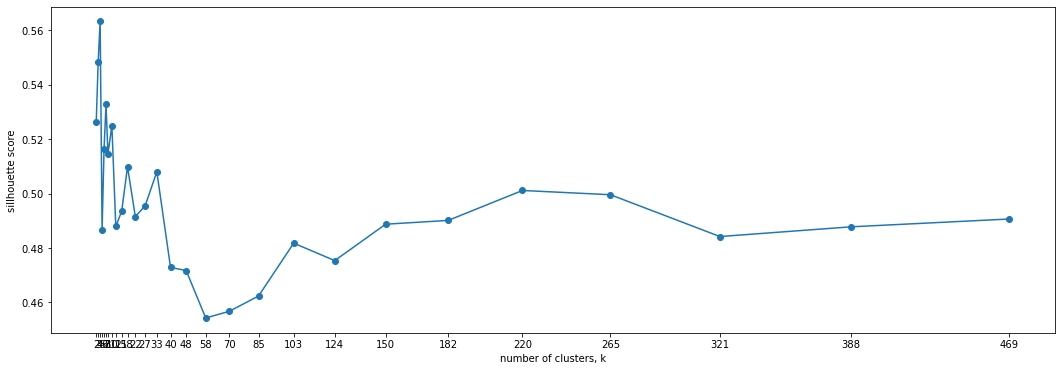

In [65]:
plt.figure(figsize=(18, 6))
plt.plot(K, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('sillhouette score')
plt.xticks(K)
plt.show()

Widzimy początkowy skok wyniku, później spadek i kolejne ekstremum w okolicach ```n_clusters=220```. Zobaczmy jak wygląda klastrowanie dla różnych parametrów tym algorytmem. Wykresy narysujemy tylko dla mniejszych wartości ```n_clusters```, ponieważ przy dużych wartościach wykres staje się nieczytelny.

In [69]:
agg_c_21 = AgglomerativeClustering(n_clusters=21).fit(samples[:subset_size])
agg_c_26 = AgglomerativeClustering(n_clusters=26).fit(samples[:subset_size])
agg_c_30 = AgglomerativeClustering(n_clusters=30).fit(samples[:subset_size])
agg_c_35 = AgglomerativeClustering(n_clusters=35).fit(samples[:subset_size])

In [73]:
models = [
    agg_c_21, kmeans_21,
    agg_c_26, kmeans_26,
    agg_c_30, kmeans_30,
    agg_c_35, kmeans_35
]

Poniżej przedstawione jest porównanie obu algorytmów. W lewej kolumnie znajdują się klastry stworzone za pomocą ```AgglomerativeClusterin``` a w prawej za pomocą ```KMeans```.

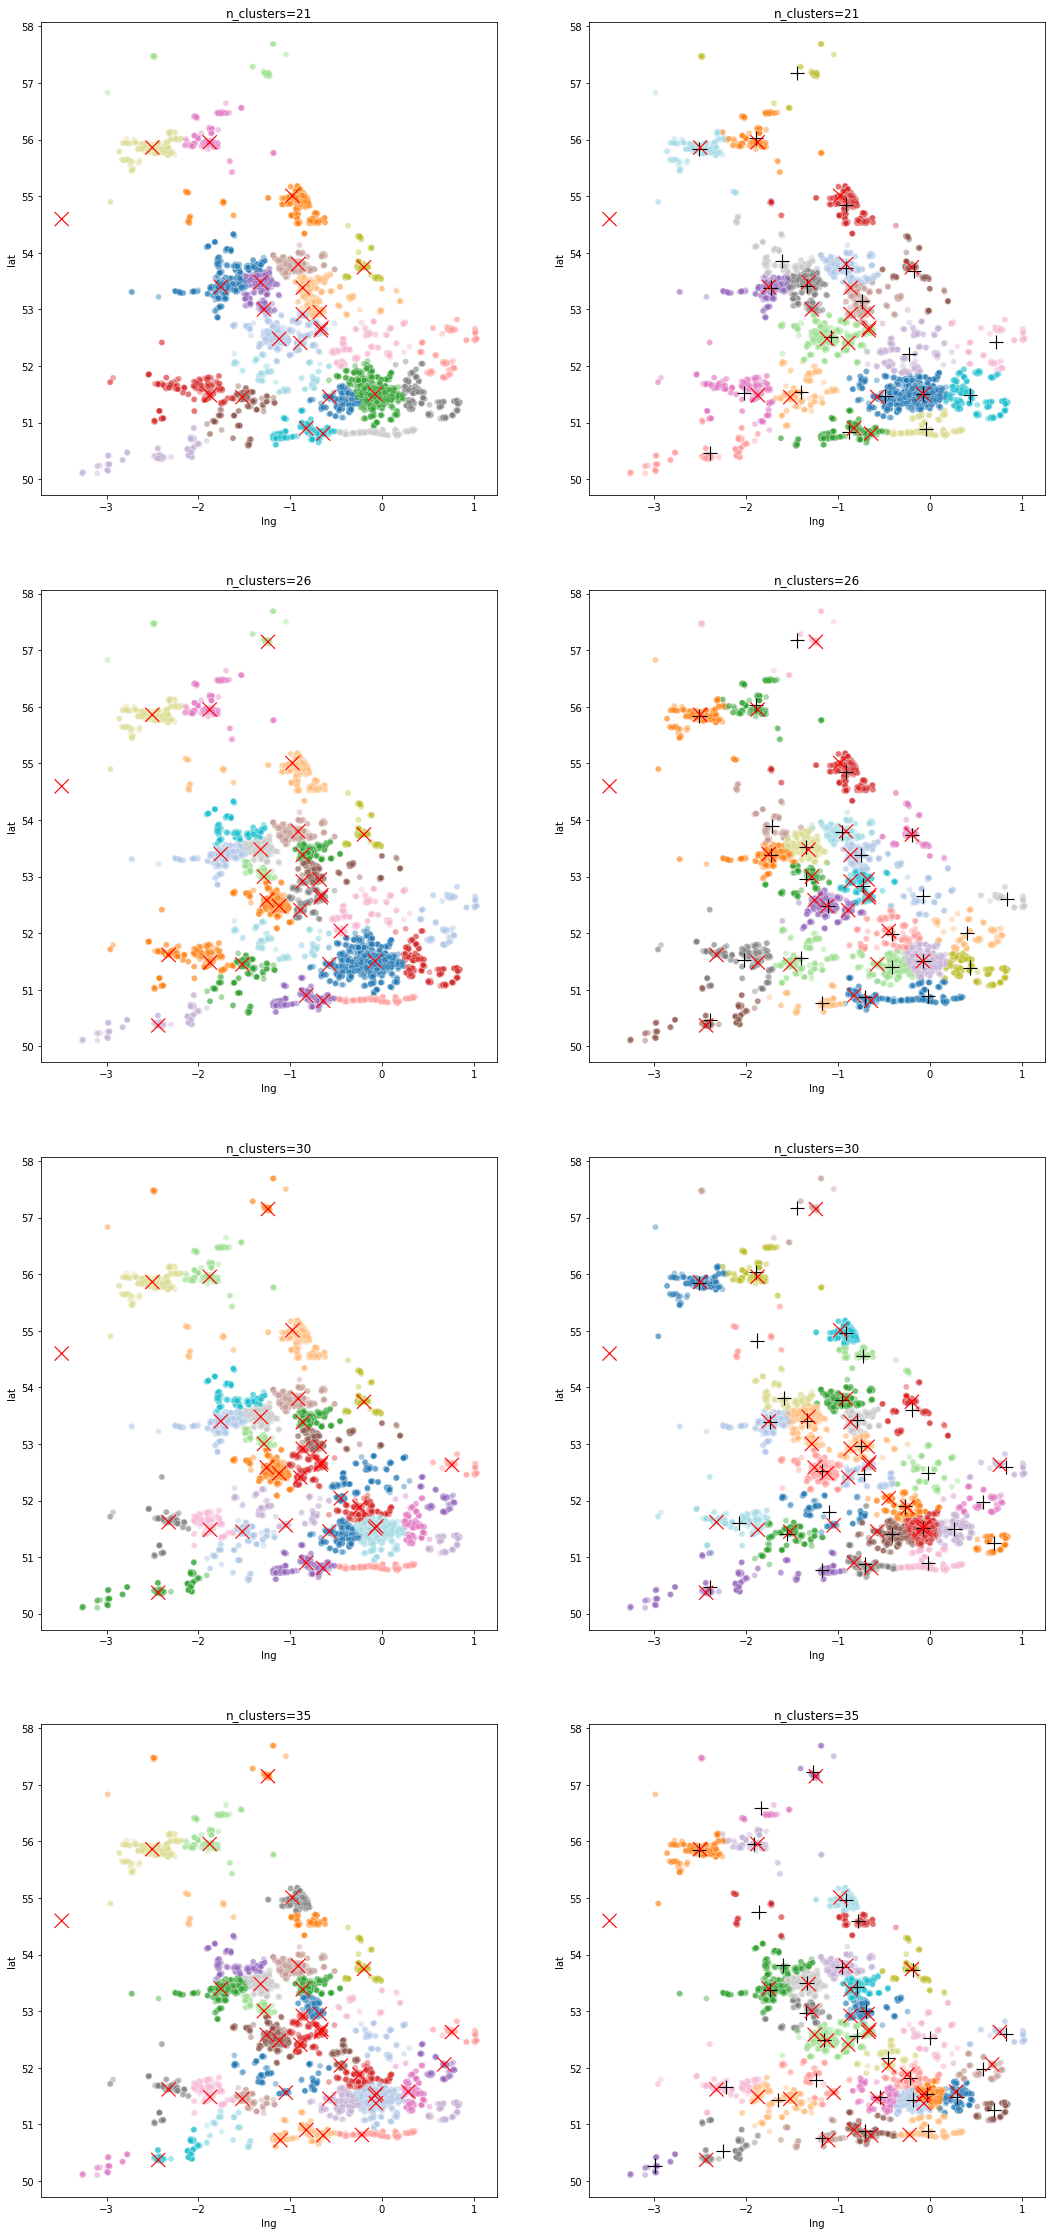

In [76]:
plot_clusters_over_cities(samples[:subset_size], models)

```AgglomerativeClustering``` zdaje się lepiej oddawać naturę i położenie skupisk miast natomiast ```KMeans``` jest w stanie drobniej podzielić dane na poszczególne miasta. Jest to w szczególności widoczne w okolicach Londynu.

### Podsumowanie

Do wyznaczenia liczby klastrów wykorzystaliśmy dwie metody. Żadna z nich nie dała nam jednoznacznego wyniku jednak optymalna liczba klastrów zdaje się być w okolicach 20-30. Ma też sens zwiększenie liczby klastrów do ponad 200, ponieważ zaobserwowaliśmy tam wzrost ```silhouette score```.

Oba wykorzystane algorytmy zdają się dobrze odwzorowywać położenie miast co wskazuje na ich użyteczność w praktycznym zastosowaniu.